# SBERMARKET COMPETITION

## Predict the user's next order

### Data Description

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

#### `train.csv`:

- **`user_id`** - уникальный id пользователя
- **`order_completed_at`** - дата заказа
- **`cart`** - список уникальных категорий (`category_id`), из которых состоял заказ

#### **OBJECTIVE** 
> **В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае.**


Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

#### `sample_submission.csv`:

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- **`id`** - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: `f'{user_id};{category_id}'`. Из-за особенностей проверяющей системы `Kaggle InClass`, использовать колонки `user_id`, `category_id` в качестве индекса отдельно невозможно

- **`target`** - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

### IMPORT LIBRARIES

In [1]:
#  !pip install -U statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
sns.set_style('whitegrid')

import statsmodels.api as sm
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

### LOAD DATA

In [3]:
# Path to data
data_path = "/content/drive/MyDrive/ML_Portfolio/Project 2: SberMarket Competition/data/train.csv"

subm_path = "/content/drive/MyDrive/ML_Portfolio/Project 2: SberMarket Competition/data/sample_submission.csv"

In [4]:
# Load the data
data_df = pd.read_csv(data_path)

# Check result 
data_df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


# EXPLORATORY DATA ANALYSIS

In [5]:
# The shape of the original data set
print("The shape of the original data set:\n{}".format(data_df.shape))

The shape of the original data set:
(3123064, 3)


In [6]:
# Verify data quality
def verify_data_quality (evaluated_dataset):
    # Data type checking
    print("Data types:\n{}\n".format(evaluated_dataset.dtypes) + '_' * 100+ '\n')

    # Checking for NaN values
    print("Missing values:\n{}\n".format(evaluated_dataset.isnull().sum().sum()) + '_' * 100+ '\n')

    # Number of values other than NaN
    print("Number of values other than NaN:\n{}\n".format(evaluated_dataset.count().sum()) + '_' * 100+ '\n')

    # Search for duplicate strings
    print("Duplicate strings:\n{}\n".format(evaluated_dataset.duplicated().sum()) + '_' * 100+ '\n')

    # Data Set form
    print("Dataset form:\n{}\n".format(evaluated_dataset.shape) + '_' * 100+ '\n')

    # Data set index type
    print("Dataset index:\n{}\n".format(evaluated_dataset.index) + '_' * 100+ '\n')

In [7]:
verify_data_quality(data_df)

Data types:
user_id                int64
order_completed_at    object
cart                   int64
dtype: object
____________________________________________________________________________________________________

Missing values:
0
____________________________________________________________________________________________________

Number of values other than NaN:
9369192
____________________________________________________________________________________________________

Duplicate strings:
0
____________________________________________________________________________________________________

Dataset form:
(3123064, 3)
____________________________________________________________________________________________________

Dataset index:
RangeIndex(start=0, stop=3123064, step=1)
____________________________________________________________________________________________________



Из анализа качества данных видно, что представленные данные имеют относительно высокое качество т.к. нет пропущенных и дублирующих значений.  Однако переменная `order_completed_at` имеет тип `object`, поэтому ее необходимо в дальнейшем конвертировать в тип `datetime`.

#### Variable Types

- **user_id** - nominal variable             
- **order_completed_at** - time 
- **cart** - nominal variable     

#### Data type conversions

In [8]:
data_df['order_completed_at'] = pd.to_datetime(data_df['order_completed_at'])

#Check result 
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


### Distribution analysis

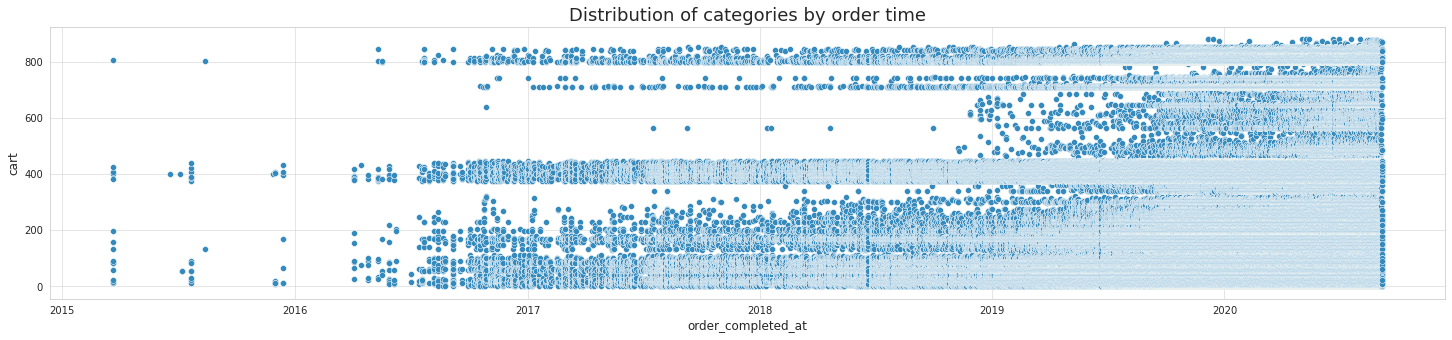

In [9]:
plt.subplots(figsize=(25, 5))
sns.scatterplot(data=data_df, x='order_completed_at', y='cart')
plt.title("Distribution of categories by order time", fontsize=18)
plt.show()

Анализ распределения категорий по времени заказа показывает, что примерно с середины 2016 года и до конца доступных наблюдений т.е. середины 2020 года есть ряд категорий, которые пользуются постоянной популярностью.  

Эти категории необходимо исследовать дополнительно далее.  ( См. раздел. [«Analysis of the best-selling products of all time»]( https://colab.research.google.com/drive/1Ne4Ltvos7VO_QFY1MZ3i-eqTZ-s_Zmd9?authuser=1#scrollTo=96ZtX9DJAitY&line=1&uniqifier=1)) 

Также можно заметить, что начиная с середины 2019 года резко растет количество категорий заказов, что может быть связанно с увеличением количества последних.  (Детальный анализ трендов смотрите в разделе [Trend analysis](https://colab.research.google.com/drive/1Ne4Ltvos7VO_QFY1MZ3i-eqTZ-s_Zmd9?authuser=1#scrollTo=kiD4k25g9kH7&line=1&uniqifier=1) )


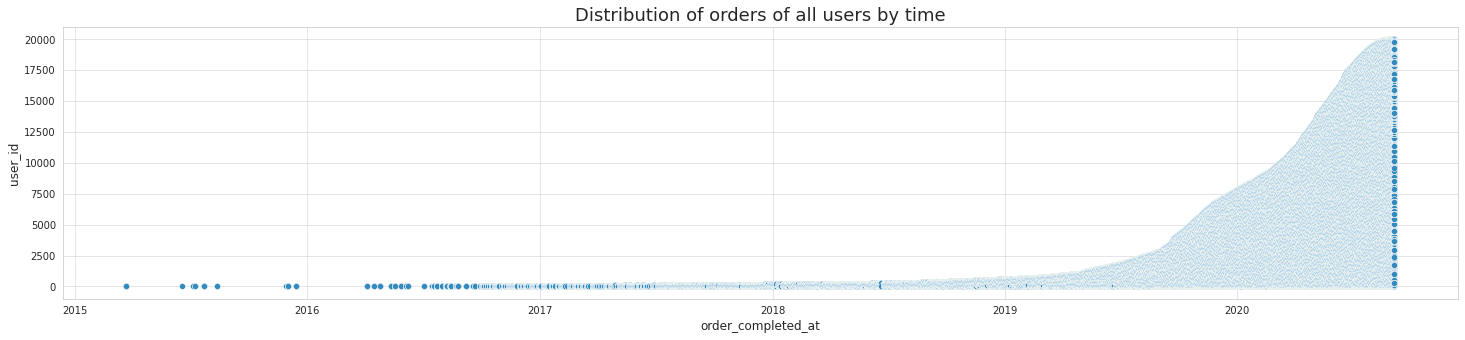

In [10]:
plt.subplots(figsize=(25, 5))
sns.scatterplot(data=data_df, x='order_completed_at', y=data_df.user_id)
plt.title("Distribution of orders of all users by time", fontsize=18)
plt.show()

Предыдущие выводы о резком возрастании категорий заказов также подтверждаются анализом распределения заказов по времени.  Из графика видно, что начиная со второй половины 2019 года практически экспоненциально растет число заказов.  Это может быть связанно с изменением потребительского поведения из-за пандемии короновируса. 

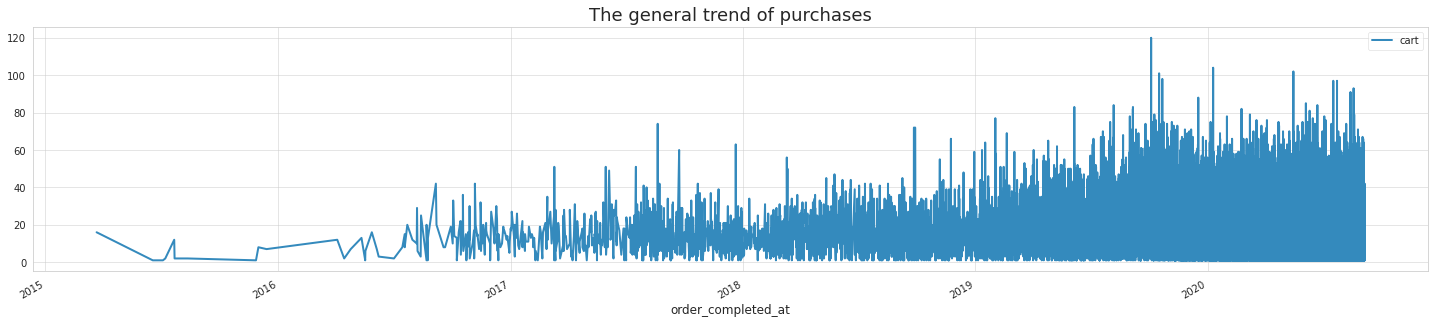

In [11]:
general_trend = data_df.groupby('order_completed_at')['cart'].count().to_frame()
general_trend.plot(figsize=(25, 5))
plt.title("The general trend of purchases", fontsize=18)
plt.show()

Анализ увеличения числа продаж в виде временного ряда показывает, что есть устойчивый рост с средины 2016 года и до примерно третьего квартала 2019 года, после чего можно заметить уровень сопротивления в районе значения 80 с его регулярными незначительными и не долговременными пробитиями.  

Необходим более детальный анализ трендов за разные интервалы времени. (Детальный анализ трендов смотрите в разделе [Trend analysis](https://colab.research.google.com/drive/1Ne4Ltvos7VO_QFY1MZ3i-eqTZ-s_Zmd9?authuser=1#scrollTo=kiD4k25g9kH7&line=1&uniqifier=1) )


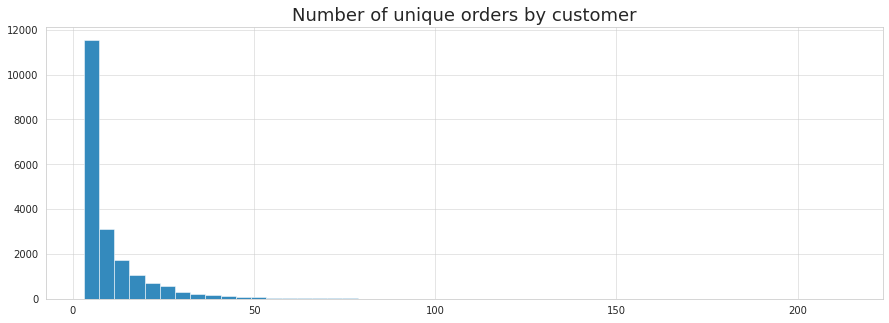

In [12]:
plt.subplots(figsize=(15, 5))
data_df.groupby('user_id')['order_completed_at'].nunique().hist(bins=50)
plt.title('Number of unique orders by customer',fontsize=18)
plt.show()

Анализ количества числа уникальных по клиентам показывает, что есть небольшое количество клиентов, которые генерируют больше всего уникальных заказов, а далее уникальность резко снижается и формируется длинный «правый» хвост не уникальных заказов. Т.е. большая часть заказов имеет не уникальный характер. 

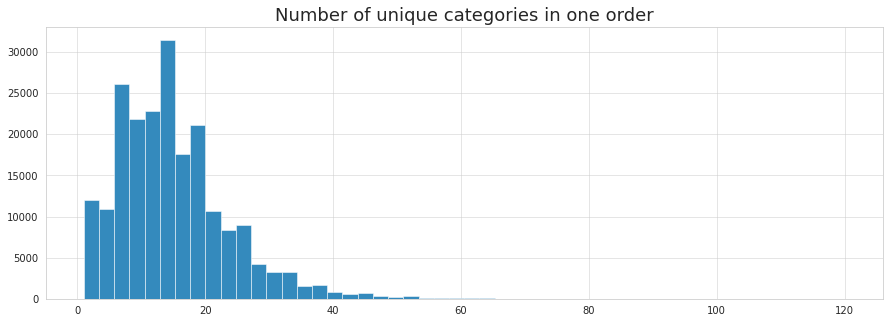

In [13]:
plt.subplots(figsize=(15, 5))
data_df.groupby(['user_id', 'order_completed_at'])['cart'].count().hist(bins=50);
plt.title('Number of unique categories in one order',fontsize=18)
plt.show()

In [14]:
def distribution(data_for_eda): 
    print("Descriptive statistics:\n{}\n".format(data_for_eda.describe().round(2)) + '_' * 100+ '\n')
    print("Skew:\n{}\n".format(data_for_eda.skew().round(2))+ '_' * 100+ '\n')
    print("Kurtosis:\n{}\n".format(data_for_eda.kurt().round(2)) + '_' * 100+ '\n')

In [15]:
distribution(data_df.groupby(['user_id', 'order_completed_at'])['cart'].count())

Descriptive statistics:
count    209406.00
mean         14.91
std           8.80
min           1.00
25%           9.00
50%          13.00
75%          19.00
max         120.00
Name: cart, dtype: float64
____________________________________________________________________________________________________

Skew:
1.24
____________________________________________________________________________________________________

Kurtosis:
3.14
____________________________________________________________________________________________________



Анализ числа уникальных категорий в заказе, показывает, что оно имеет распределение близкое к нормальному, что также подтверждается анализом описательных статистик т.к. средине (14.91)  и медиана (13.00) не сильно различаются, при этом значения смещения равно 1.24, а эксцесс равен 3.14. 

In [16]:
print("Median number of orders per customer:", \
      data_df.groupby('user_id')['order_completed_at'].nunique().median())

print("Median number of unique categories in one order:", \
data_df.groupby(['user_id', 'order_completed_at'])['cart'].count().median())

print("Median number of unique categories in all orders of one customer:", \
data_df.groupby('user_id')['cart'].nunique().median())

Median number of orders per customer: 6.0
Median number of unique categories in one order: 13.0
Median number of unique categories in all orders of one customer: 49.0


In [17]:
print("Mean number of orders per customer:", \
      data_df.groupby('user_id')['order_completed_at'].nunique().mean())

print("Mean number of unique categories in one order:", \
data_df.groupby(['user_id', 'order_completed_at'])['cart'].count().mean())

print("Mean number of unique categories in all orders of one customer:", \
data_df.groupby('user_id')['cart'].nunique().mean())

Mean number of orders per customer: 10.4703
Mean number of unique categories in one order: 14.913918416855296
Mean number of unique categories in all orders of one customer: 55.88


In [18]:
print("Maximum number of orders per customer:", \
      data_df.groupby('user_id')['order_completed_at'].nunique().max())

print("Maximum number of unique categories in one order:", \
data_df.groupby(['user_id', 'order_completed_at'])['cart'].count().max())

print("Maximum number of unique categories in all orders of one customer:", \
data_df.groupby('user_id')['cart'].nunique().max())

Maximum number of orders per customer: 213
Maximum number of unique categories in one order: 120
Maximum number of unique categories in all orders of one customer: 250


In [19]:
print("Minimum number of orders per customer:", \
      data_df.groupby('user_id')['order_completed_at'].nunique().min())

print("Minimum number of unique categories in one order:", \
data_df.groupby(['user_id', 'order_completed_at'])['cart'].count().min())

print("Minimum number of unique categories in all orders of one customer:", \
data_df.groupby('user_id')['cart'].nunique().min())

Minimum number of orders per customer: 3
Minimum number of unique categories in one order: 1
Minimum number of unique categories in all orders of one customer: 1


### Trend analysis

Анализ трендов выполнен на основании декомпозиции временного ряда общего числа продаж ([The general trend of purchases]( https://colab.research.google.com/drive/1Ne4Ltvos7VO_QFY1MZ3i-eqTZ-s_Zmd9?authuser=1#scrollTo=GWnozwYG94dk&line=3&uniqifier=1))

Для временных интервалов:
- Неделя (7 дней) 
- Месяц (30 дней)
- Два месяца (60 дней)
- Полгода (182 дня)
- Год (365 дней)


In [20]:
def decomposition(data_for_eda, period=365):
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
        
    decomposition = sm.tsa.seasonal_decompose(data_for_eda, model='multiplicative', period=period)
    
    decomposition.plot()

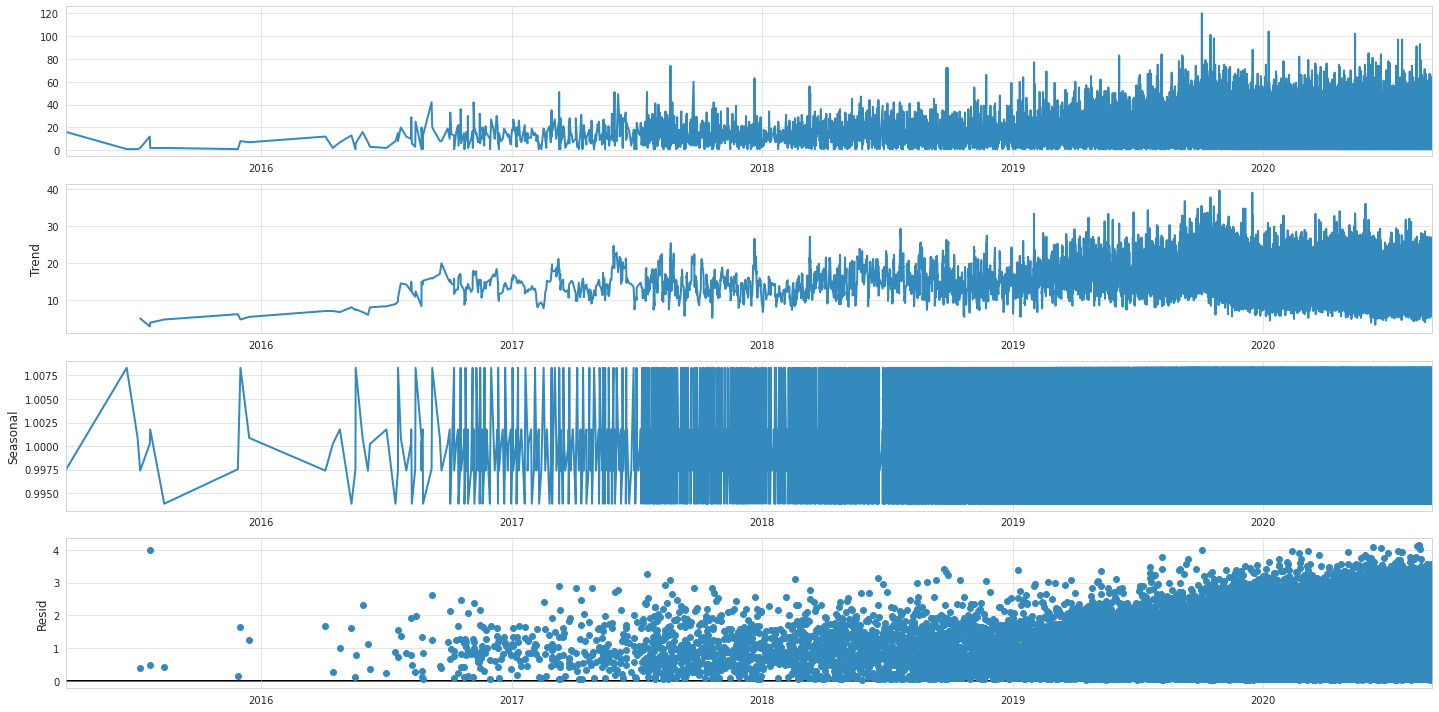

In [21]:
# Decomposition for 7 days
decomposition(general_trend, period=7)

На недельном интервале видно, что примерно с третьего квартала 2016 года и по середину 2017 года на данном окне прослеживается четкая сезонность заказов, которая начиная со второй половины 2017 года слабеет и со второй половины 2018 пропадает полностью.   

Также видно, что общий тренд на данном интервале примерно со второго квартала 2017 года и по середину 2018 оставался в одном «коридоре».  

В январе 2018 года четко заметно снижение тренда на недельном диапазоне, чего не наблюдается в последующие года, что может указывать на изменения в поведении клиентов. 


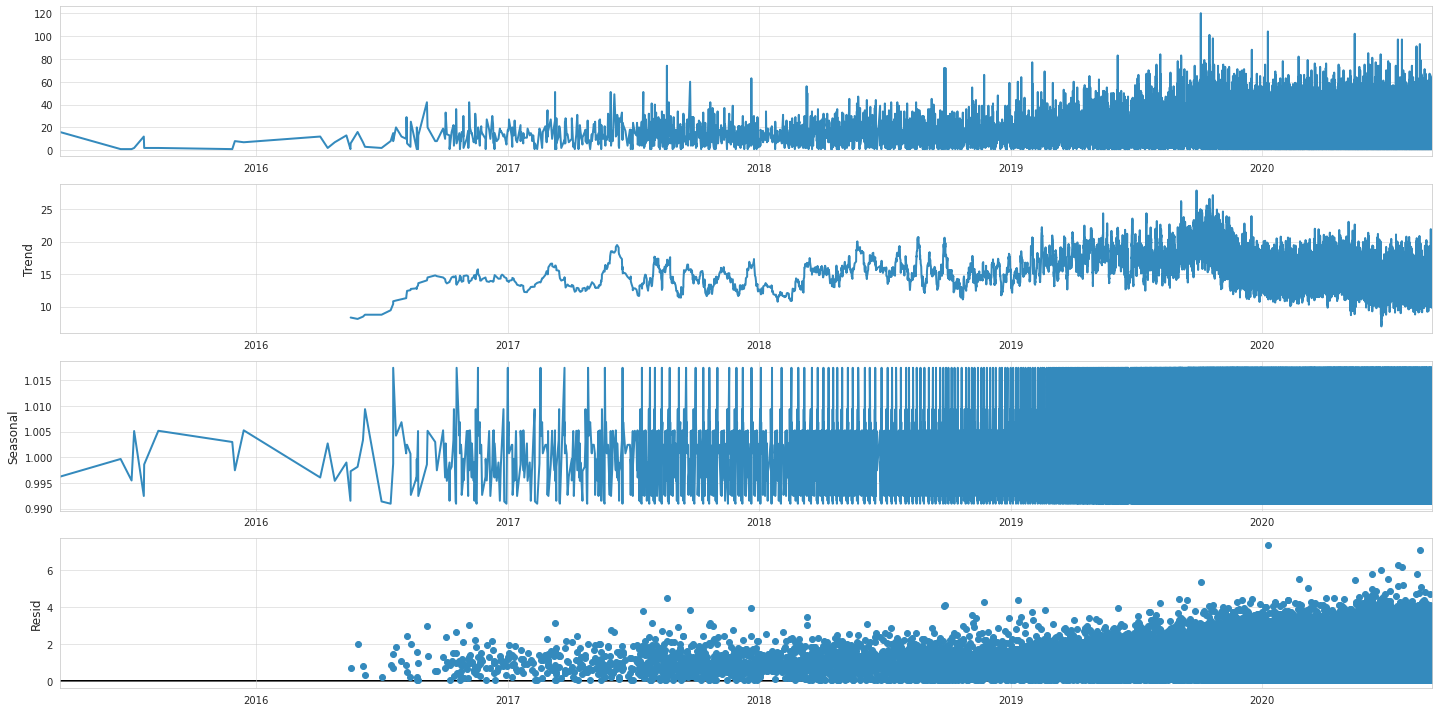

In [22]:
# Decomposition for 30 days
decomposition(general_trend, period=30)

Анализ тренда на 30 дневном интервале отчётливо обнаруживает и подтверждается выводы сделанные при анализе 7-ми дневного тренда.  

Также видно, что в 2017 и 2018 годах имеются повторяющиеся пики, что указывает на наличие сезонных колебаний в заказах клиентов, которые полностью отсутствуют в  2019 и 2020 годах. Что может указывать о серьезных поведенческих изменениях клиентов. 


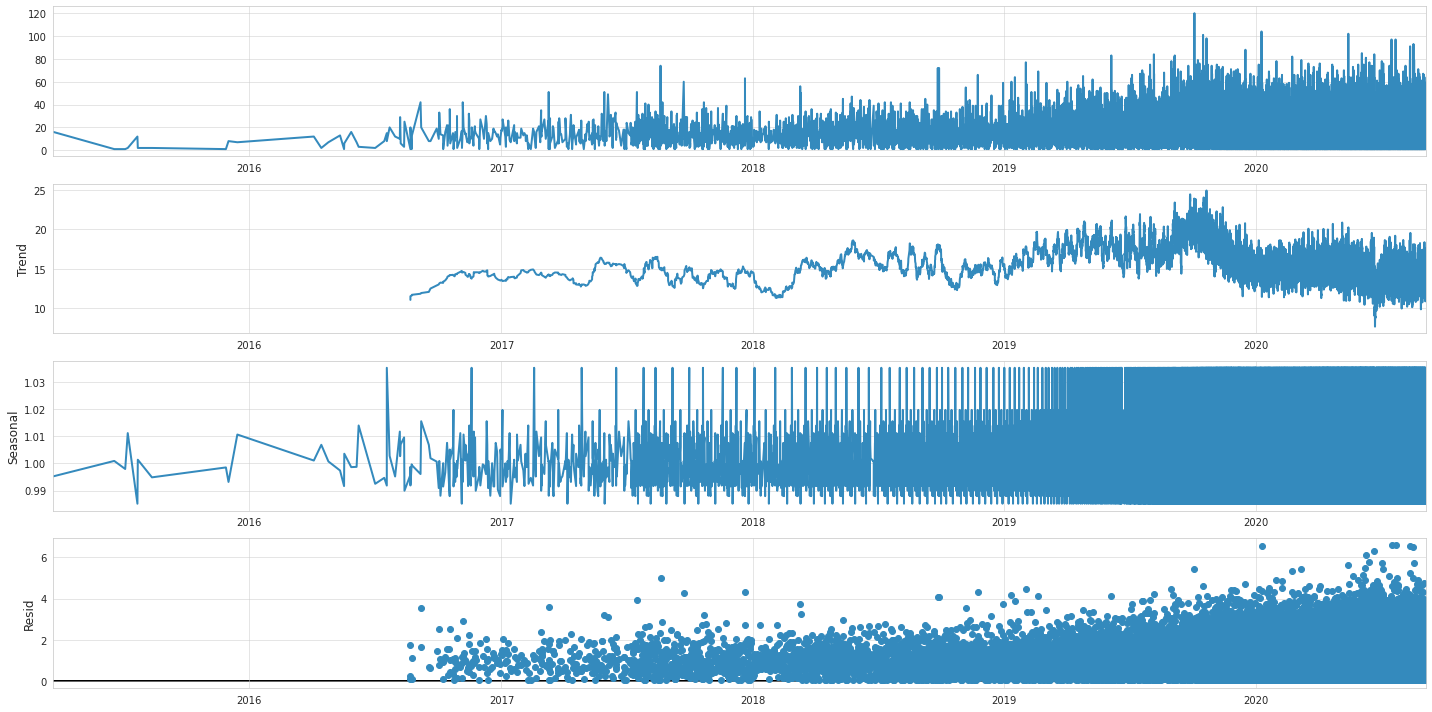

In [23]:
# Decomposition for 60 days
decomposition(general_trend, period=60)

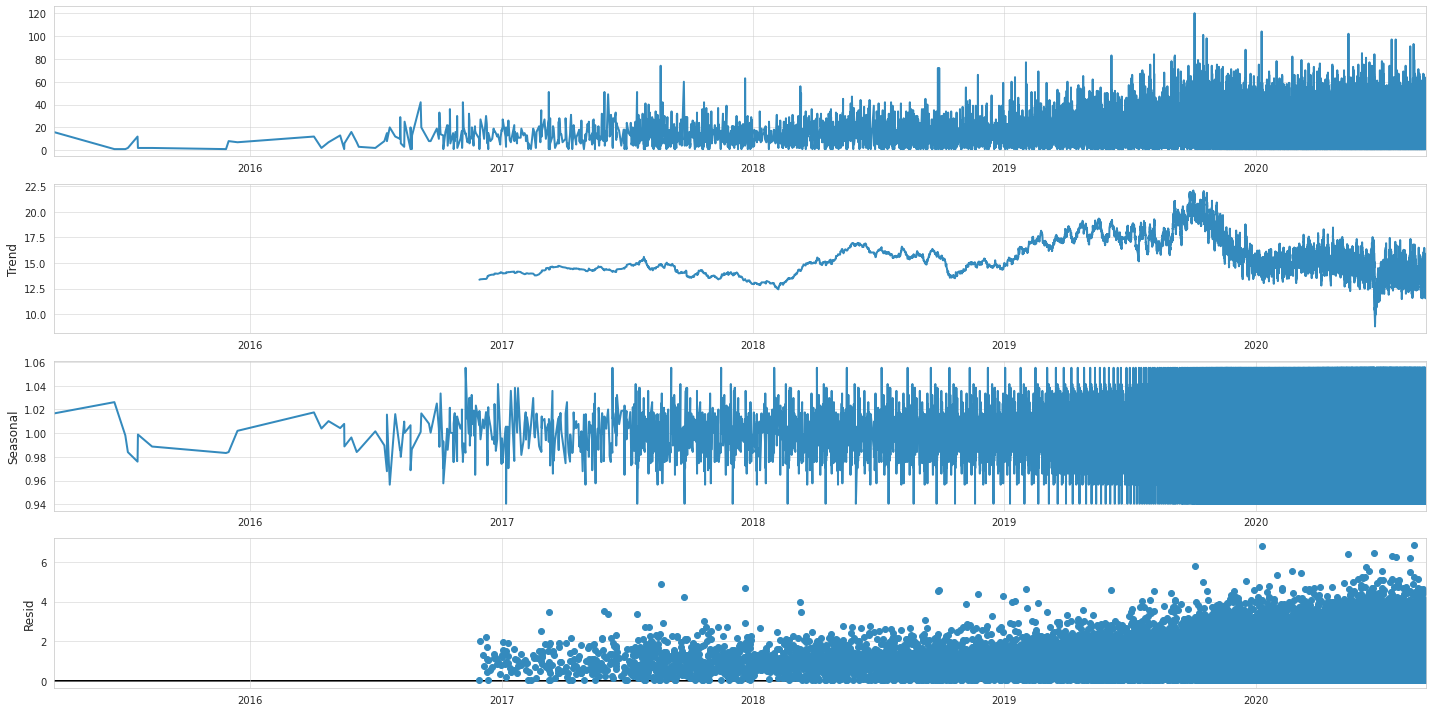

In [24]:
# Decomposition for 182 days
decomposition(general_trend, period=182)

Анализ сезонности на полугодовом интервале указывает, что имеются явные сезонные пики, которые наблюдаются с середины 2017 года и плавно затухают к середине 2019 года, что указывает на значительные изменения в поведении клиентов. 

Анализ трендов показывает, что с первого квартала 2019 года и до конца второго тренд находился в определенном «коридоре», который он пробил в третьем, достигнув максимума, после чего началось снижение и закрепление тренда в определённом диапазоне практически полностью весь 2020 год. 

При этом следует отметить, с третьего квартала 2019 года не смотря на снижающийся тренд возросла активность клиентов, о чем свидетельствует резкое увеличение амплитуды колебаний по сравнению со всей остальной историей наблюдений.  


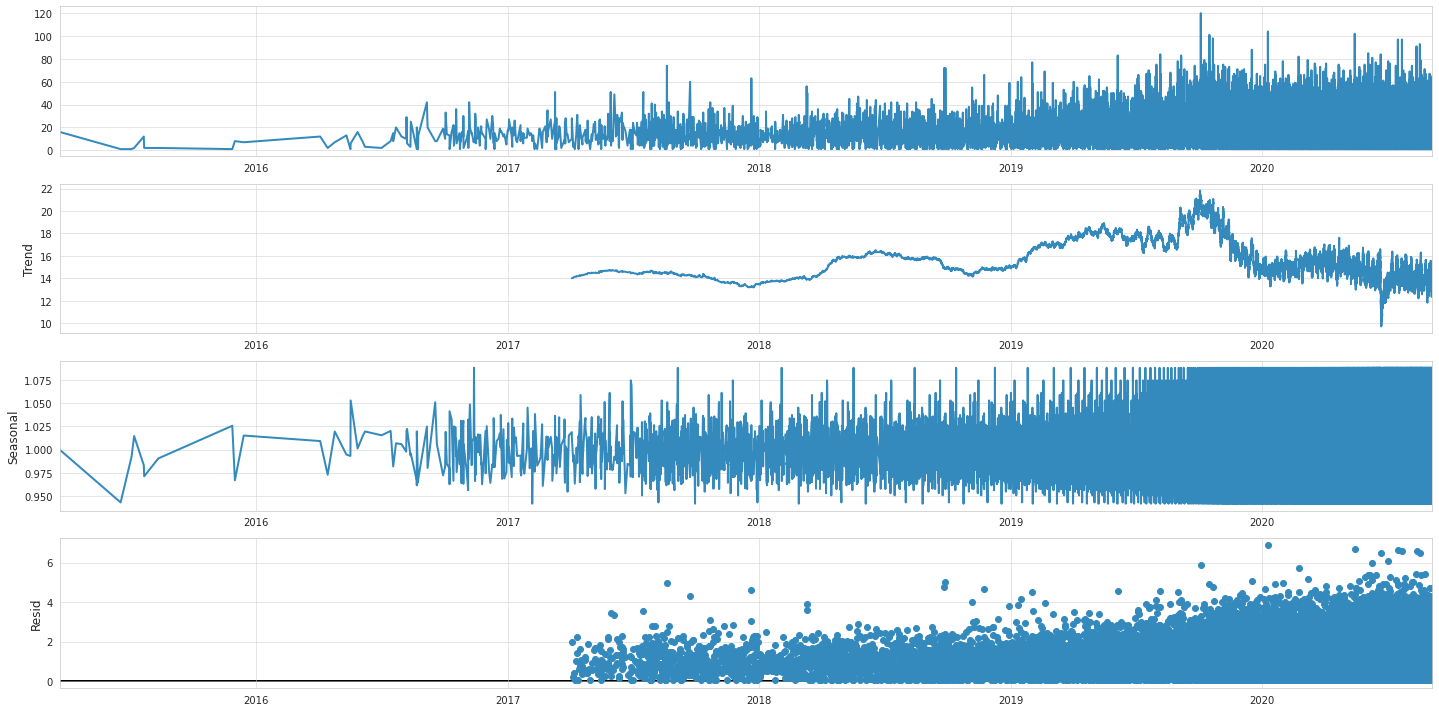

In [25]:
# Decomposition for 365 days
decomposition(general_trend, period=365)

Анализ декомпозиции временного ряда общего числа продаж за годовой период подтверждает выводы сделанные при анализе полугодовой декомпозиции. 

### Analysis of the best-selling products of all time

In [26]:
best_selling_products = data_df['cart'].value_counts().head().to_frame()
index = best_selling_products.index.values.tolist()

In [27]:
best_selling_products_by_year = data_df.copy()
best_selling_products_by_year['year'] = best_selling_products_by_year['order_completed_at'].dt.year
best_selling_products_by_year = best_selling_products_by_year.drop(['user_id', 'order_completed_at'], axis=1).set_index('year')

In [28]:
best_selling_products_by_year.groupby('year').count()

,cart
year,
2015,52
2016,1375
2017,8938
2018,25464
2019,603398
2020,2483837


Dynamics of sales of goods with an index 57


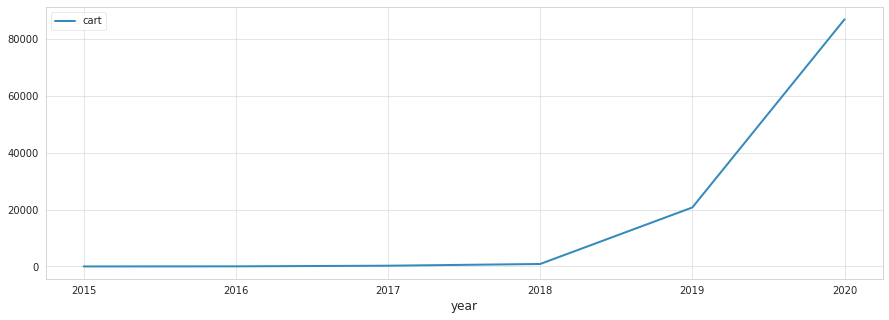

Dynamics of sales of goods with an index 14


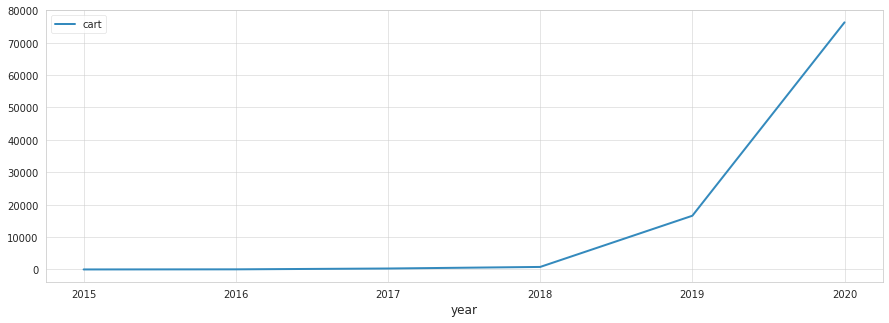

Dynamics of sales of goods with an index 61


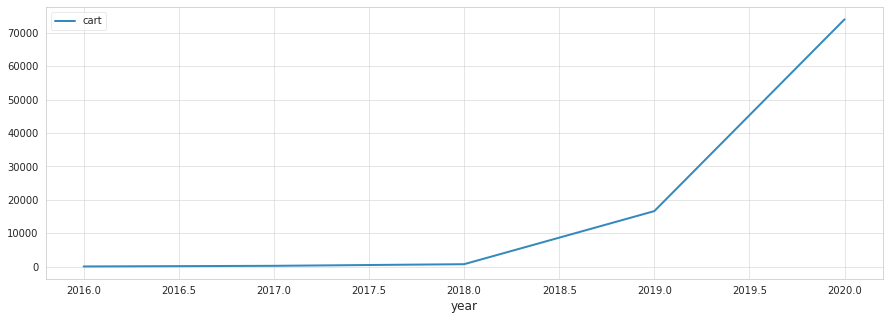

Dynamics of sales of goods with an index 398


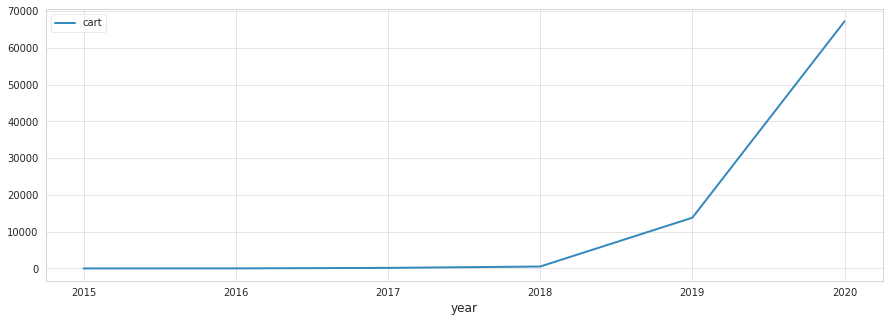

Dynamics of sales of goods with an index 23


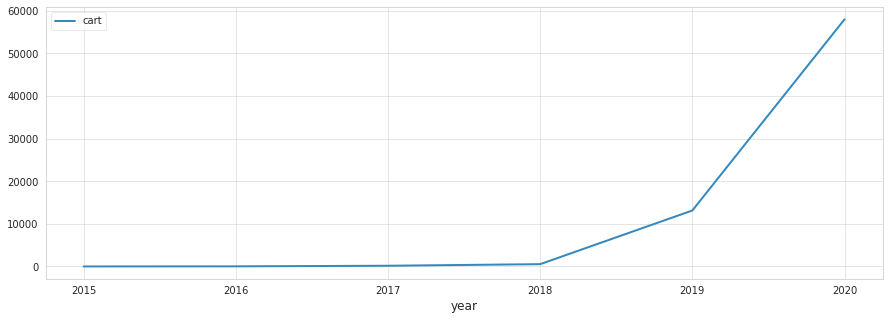

In [29]:
for ind in index:
    print(f'Dynamics of sales of goods with an index {ind}')
    best_selling_products_by_year.loc[best_selling_products_by_year['cart'] == ind].groupby('year').count().plot(figsize=(15, 5))
    plt.show()

Анализ динамики продаж наиболее популярных товаров в целом согласуется с выводами от анализа декомпозиции временного ряда общего числа продаж и указывает, что начиная с 2018 года и по 2020 год наблюдается значительный рост продаж наиболее популярных товаров. 

## GENERAL CONCLUSIONS ON EXPLORATORY DATA ANALYSIS

- Представленные данные имеют относительно высокое качество т.к. нет пропущенных и дублирующих значений.  

- Анализ распределения категорий по времени заказа показывает, что примерно с середины 2016 года и до конца доступных наблюдений т.е. середины 2020 года есть ряд категорий, которые пользуются постоянной популярностью.  

- Начиная с середины 2019 года резко растет количество категорий заказов, что может быть связанно с увеличением количества последних. 

- Выводы о резком возрастании категорий заказов также подтверждаются анализом распределения заказов по времени. Из графика видно, что начиная со второй половины 2019 года практически экспоненциально растет число заказов. Это может быть связанно с изменением потребительского поведения из-за пандемии короновируса.

- Анализ увеличения числа продаж в виде временного ряда показывает, что есть устойчивый рост с средины 2016 года и до примерно третьего квартала 2019 года, после чего можно заметить уровень сопротивления в районе значения 80 с его регулярными незначительными и не долговременными пробитиями.  

- Есть небольшое количество клиентов, которые генерируют больше всего уникальных заказов, а далее уникальность резко снижается и формируется длинный «правый» хвост не уникальных заказов. Т.е. большая часть заказов имеет не уникальный характер.

- Число уникальных категорий в заказе, показывает, что оно имеет распределение близкое к нормальному, что также подтверждается анализом описательных статистик т.к. средине (14.91)  и медиана (13.00) не сильно различаются, при этом значения смещения равно 1.24, а эксцесс равен 3.14. 

- При анализе тренда на недельном интервале видно, что примерно с третьего квартала 2016 года и по середину 2017 года на данном окне прослеживается четкая сезонность заказов, которая начиная со второй половины 2017 года слабеет и со второй половины 2018 пропадает полностью.  Также видно, что общий тренд на данном интервале примерно со второго квартала 2017 года и по середину 2018 оставался в одном «коридоре». В январе 2018 года четко заметно снижение тренда на недельном диапазоне, чего не наблюдается в последующие года, что может указывать на изменения в поведении клиентов. 

- Анализ тренда на 30 дневном интервале отчётливо обнаруживает и подтверждается выводы, сделанные при анализе 7-ми дневного тренда. Также видно, что в 2017 и 2018 годах имеются повторяющиеся пики, что указывает на наличие сезонных колебаний в заказах клиентов, которые полностью отсутствуют в  2019 и 2020 годах. Что может указывать о серьезных поведенческих изменениях клиентов. 

- Анализ сезонности на полугодовом интервале указывает, что имеются явные сезонные пики, которые наблюдаются с середины 2017 года и плавно затухают к середине 2019 года, что указывает на значительные изменения в поведении клиентов. Анализ трендов показывает, что с первого квартала 2019 года и до конца второго тренд находился в определенном «коридоре», который он пробил в третьем, достигнув максимума, после чего началось снижение и закрепление тренда в определённом диапазоне практически полностью весь 2020 год. При этом следует отметить, с третьего квартала 2019 года не смотря на снижающийся тренд возросла активность клиентов, о чем свидетельствует резкое увеличение амплитуды колебаний по сравнению со всей остальной историей наблюдений.  

- Анализ декомпозиции временного ряда общего числа продаж за годовой период подтверждает выводы сделанные при анализе полугодовой декомпозиции. 

- Анализ динамики продаж наиболее популярных товаров в целом согласуется с выводами от анализа декомпозиции временного ряда общего числа продаж и указывает, что начиная с 2018 года и по 2020 год наблюдается значительный рост продаж наиболее популярных товаров. 

# FEATURE ENGINEERING

In [30]:
train_df = data_df.copy()
train_df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [31]:
train_df.shape

(3123064, 3)

In [107]:
test_df = pd.read_csv(subm_path)
test_df.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [108]:
test_df.shape

(790449, 2)

In [109]:
# Let's split the column id into user_id and cart
test_df['user_id'] = test_df['id'].map(lambda x: x.split(';')[0]).astype(int)
test_df['item_id'] = test_df['id'].map(lambda x: x.split(';')[1]).astype(int)
test_df.drop('id', axis=1, inplace=True)
test_df.head()

,target,user_id,item_id
0,0,0,133
1,1,0,5
2,0,0,10
3,1,0,396
4,0,0,14


In [35]:
train_df.drop('order_completed_at', axis=1, inplace=True)

In [36]:
train_df['target'] = train_df.duplicated(keep=False).apply(lambda x: 1 if x == True else 0)
train_df.head()

,user_id,cart,target
0,2,399,0
1,2,14,0
2,2,198,1
3,2,88,1
4,2,157,1


 # DATA PREPARATION

In [37]:
X = train_df.drop("target", axis=1)

y = train_df.target.values

In [38]:
X_norm = Normalizer().fit_transform(X)
X_norm

array([[0.00501247, 0.99998744],
       [0.14142136, 0.98994949],
       [0.01010049, 0.99994899],
       ...,
       [0.99942482, 0.03391215],
       [0.99999821, 0.00188946],
       [0.99942748, 0.03383356]])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# MACHINE LEARNING MODELS

### Test 3 classic models
1. Logistic Regression 
1. K-Nearest Neighbors
1. RandomForest

In [41]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

In [42]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [43]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_val,
                             y_train=y_train,
                             y_test=y_val)
model_scores

{'KNN': 0.8359688319007129,
 'Logistic Regression': 0.8209083064233373,
 'Random Forest': 0.8787649312454272}

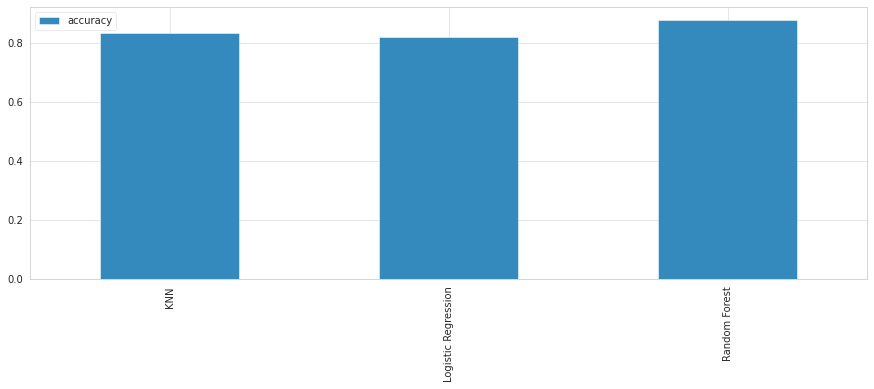

In [44]:
# Model Comparison
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar(figsize=(15, 5));

### Hyperparameter tuning

In [45]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n' + classification_report(y_train_true, y_train_pred)+ '_' * 70+ '\n')
    print('TEST\n' + classification_report(y_test_true, y_test_pred)+ '_' * 70+ '\n')
    print('CONFUSION MATRIX\n'+ '_' * 70+ '\n')
    print(pd.crosstab(y_test_true, y_test_pred))

#### Tune KNeighborsClassifier

In [46]:
#List Hyperparameters 
leaf_size = list(range(50, 250, 50))
n_neighbors = list(range(5, 50, 10))
p=[1,2]

#Convert to dictionary
hyperparameters_KNN = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

gs_KNN = GridSearchCV(KNeighborsClassifier(),
                      param_grid=hyperparameters_KNN,
                      cv=5,
                      verbose=True)

# Fit grid hyperparameter search model
gs_KNN.fit(X_val, y_val)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [50, 100, 150, 200],
                         'n_neighbors': [5, 15, 25, 35, 45], 'p': [1, 2]},
             verbose=True)

In [47]:
# Check the best parameters
gs_KNN.best_params_

{'leaf_size': 50, 'n_neighbors': 35, 'p': 1}

In [48]:
# Evaluate the model
gs_KNN.score(X_test, y_test)

0.8287099371931099

In [49]:
y_train_pred = gs_KNN.predict(X_train)
y_test_pred = gs_KNN.predict(X_test)

In [50]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN
              precision    recall  f1-score   support

           0       0.62      0.12      0.20    336168
           1       0.84      0.98      0.90   1537670

    accuracy                           0.83   1873838
   macro avg       0.73      0.55      0.55   1873838
weighted avg       0.80      0.83      0.78   1873838
______________________________________________________________________

TEST
              precision    recall  f1-score   support

           0       0.62      0.12      0.20    112066
           1       0.84      0.98      0.90    512547

    accuracy                           0.83    624613
   macro avg       0.73      0.55      0.55    624613
weighted avg       0.80      0.83      0.78    624613
______________________________________________________________________

CONFUSION MATRIX
______________________________________________________________________

col_0      0       1
row_0               
0      13307   98759
1       8231  504316


#### Tune Logistic Regression

In [51]:
#List Hyperparameters 
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,

                          verbose=True)
# Fit grid hyperparameter search model
gs_log_reg.fit(X_val, y_val)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03,
       1.61026203e-02, 3.03919538e-02, 5.73615251e-02, 1.08263673e-01,
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'solver': ['liblinear']},
             verbose=True)

In [52]:
# Check the best parameters
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [53]:
# Evaluate the model
gs_log_reg.score(X_test, y_test)

0.8205833051825691

In [54]:
y_train_pred = gs_log_reg.predict(X_train)
y_test_pred = gs_log_reg.predict(X_test)

In [55]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    336168
           1       0.82      1.00      0.90   1537670

    accuracy                           0.82   1873838
   macro avg       0.41      0.50      0.45   1873838
weighted avg       0.67      0.82      0.74   1873838
______________________________________________________________________

TEST
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    112066
           1       0.82      1.00      0.90    512547

    accuracy                           0.82    624613
   macro avg       0.41      0.50      0.45    624613
weighted avg       0.67      0.82      0.74    624613
______________________________________________________________________

CONFUSION MATRIX
______________________________________________________________________

col_0       1
row_0        
0      112066
1      512547


#### Tune RandomForest

In [67]:
#List Hyperparameters 
rf_grid = rf_grid = {"n_estimators": [100, 200, 300],
                     "max_depth": [None, 3, 6],
                     "min_samples_split": [3, 6],
                     "min_samples_leaf": [3, 6]}

rs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid=rf_grid,
                     cv=5,
                     verbose=True)

# Fit grid hyperparameter search model
rs_rf.fit(X_val, y_val)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 3, 6], 'min_samples_leaf': [3, 6],
                         'min_samples_split': [3, 6],
                         'n_estimators': [100, 200, 300]},
             verbose=True)

In [68]:
# Check the best parameters
rs_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 300}

In [69]:
# Evaluate the model
rs_rf.score(X_test, y_test)

0.837124747643741

In [70]:
y_train_pred = rs_rf.predict(X_train)
y_test_pred = rs_rf.predict(X_test)

In [71]:
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN
              precision    recall  f1-score   support

           0       0.60      0.27      0.38    336168
           1       0.86      0.96      0.91   1537670

    accuracy                           0.84   1873838
   macro avg       0.73      0.62      0.64   1873838
weighted avg       0.81      0.84      0.81   1873838
______________________________________________________________________

TEST
              precision    recall  f1-score   support

           0       0.60      0.27      0.38    112066
           1       0.86      0.96      0.91    512547

    accuracy                           0.84    624613
   macro avg       0.73      0.62      0.64    624613
weighted avg       0.81      0.84      0.81    624613
______________________________________________________________________

CONFUSION MATRIX
______________________________________________________________________

col_0      0       1
row_0               
0      30676   81390
1      20344  492203


# SUBMISSION

In [110]:
y_pred = rs_rf.predict(test_df[['user_id','item_id']])

In [104]:
test_df['target'] = y_pred

In [120]:
test_df.sort_values(['user_id', 'item_id'], ascending=True, inplace=True)
test_df = test_df.rename(columns={"item_id": "cart"})

In [121]:
test_df['id'] = test_df.user_id.apply(str) + ';' + test_df.cart.apply(str)
test_df

,target,user_id,cart,id
1,1,0,5,0;5
2,0,0,10,0;10
4,0,0,14,0;14
9,0,0,20,0;20
11,0,0,22,0;22
...,...,...,...,...
790439,0,19998,398,19998;398
790438,1,19998,409,19998;409
790448,1,19998,415,19998;415
790436,0,19998,420,19998;420


In [122]:
submission = pd.DataFrame({'id': test_df['id'], 'target': test_df['target']})
submission.to_csv('submission.csv', index=False)